<a href="https://colab.research.google.com/github/genaiconference/AgenticAI_GenAIHack/blob/main/02_LangGraph_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contents

* Node
* Edge
* Stream
* Build Simple Graph using LangGraph
* Example: Sentiment Analysis
* State
* Conditional Edge
* Branching
* Example: Ad Competition and Screen play writing


In [ ]:
# @title
# prompt: How to wrap text on collab notebook output

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# @title
# prompt: How to expand the hight of colab notebook output

from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})')


In [ ]:
!git clone https://github.com/genaiconference/AgenticAI_GenAIHack.git

fatal: destination path 'AgenticAI_GenAIHack' already exists and is not an empty directory.


In [ ]:
!pip install -r /content/AgenticAI_GenAIHack/requirements_agenti_ai.txt

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/content/.env")

GPT4o_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')
API_KEY = os.getenv('east_us2_API_KEY')
API_BASE = os.getenv('east_us2_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
        azure_endpoint=API_BASE,
        openai_api_version=API_VERSION,
        azure_deployment=GPT4o_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0)

In [ ]:
# Add open ai style

#Simple LangGraph
2 Nodes connected by an edge

In [ ]:
llm.invoke("Tell me an ant joke")

AIMessage(content="Sure, here's a classic ant joke for you:\n\nWhy don't ants get sick?\n\nBecause they have tiny ant-bodies!", response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 12, 'total_tokens': 36}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-49fc0bb0-474b-4214-aad1-66b62df23b56-0')

Now let's make each Node is a **function**

In [ ]:
def func_1(input_1):
    return input_1 + " First Function"

def func_2(input_2):
    return input_2 + " to Second Function"

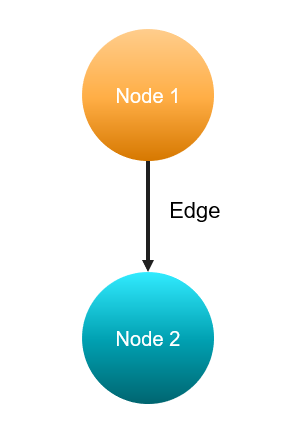

In [ ]:
from langgraph.graph import Graph

# Define a graph
workflow = Graph()

# Add nodes to the graph
workflow.add_node("node_1",func_1)
workflow.add_node("node_2",func_2)

# Time to add edge
workflow.add_edge("node_1", "node_2")

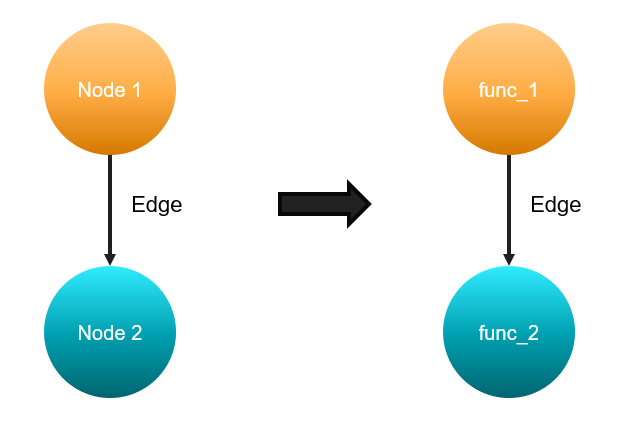

In [ ]:
#Set Entry and Exit points
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

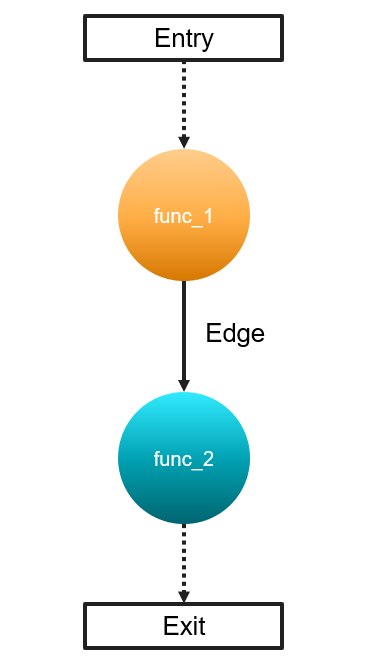

In [ ]:
app.invoke("I move from")

'I move from First Function to Second Function'

**Streaming output from LangGraph**

stream() method outputs dictionary of the format

```
{node_name : output_from_the_node}
```



In [ ]:
graph_input = 'I am moving from'
for output in app.stream(graph_input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("---\n")

Output from node 'node_1':
---
I am moving from First Function
---

Output from node 'node_2':
---
I am moving from First Function to Second Function
---



# Sentiment Analysis using LangGraph

In [ ]:
def sentiment_analysis(input_1):
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {input_1}"""

    response = llm.invoke(SA_prompt)
    return response.content

def convert_to_upper(input_2):
    Sentiment_UPPER = input_2.upper()
    response = f"Here is the SENTIMENT in UPPER case: {Sentiment_UPPER}"
    return response

In [ ]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("convert_to_upper", convert_to_upper)

workflow.add_edge('sentiment_analysis', 'convert_to_upper')

workflow.set_entry_point("sentiment_analysis")
workflow.set_finish_point("convert_to_upper")

app = workflow.compile()

### Visulize the Graph

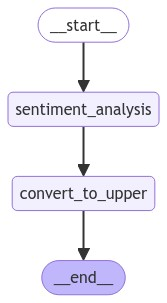

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
tweet = "The movie was so nice that I walked out in 2 min"
app.invoke(tweet)

'Here is the SENTIMENT in UPPER case: NEGATIVE'

In [ ]:
tweet = "Wish the movie was nice. But it was extraordinary"
app.invoke(tweet)

'Here is the SENTIMENT in UPPER case: POSITIVE'

### Streaming

In [ ]:
for output in app.stream(tweet):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("---\n")

Output from node 'sentiment_analysis':
---
Positive
---

Output from node 'convert_to_upper':
---
Here is the SENTIMENT in UPPER case: POSITIVE
---



# State

Now Let's introduce the state to the Graph.

One of the central concepts of LangGraph is state. Each graph execution creates a state that is passed between nodes in the graph as they execute, and each node updates this internal state with its return value after it executes.


## Benefits

-Enables stateful applications that can maintain context over multiple interactions

-Allows for coordination between multiple agents or components

-Facilitates error handling and recovery via checkpointing

-Simplifies the development of complex workflows

In [ ]:
import torch
from transformers import pipeline

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    user_review: str
    sentiment_label: str
    sentiment_label_in_upper: str


def sentiment_analysis(state):
    print("------ENTERING: SENTIMENT ANALYSIS NODE------")
    print(state)
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {state['user_review']}"""

    response = llm.invoke(SA_prompt)

    return {"sentiment_label": response.content}


def convert_to_upper(state):
    print("------ENTERING: CONVERT_TO_UPPER NODE------")
    print(state)
    Sentiment_UPPER = state['sentiment_label'].upper()
    return {"sentiment_label_in_upper": Sentiment_UPPER}



# Define a graph
workflow = StateGraph(State)

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("convert_to_upper", convert_to_upper)

workflow.add_edge('sentiment_analysis', 'convert_to_upper')

workflow.set_entry_point("sentiment_analysis")
workflow.set_finish_point("convert_to_upper")

app = workflow.compile()

### Visualize the Graph

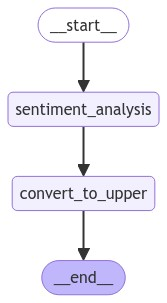

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from simple_colors import *

review = "The movie was so nice that I walked out in 2 min"
input_review = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(input_review, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': 'The movie was so nice that I walked out in 2 min'}
------ENTERING: SENTIMENT ANALYSIS NODE------
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': None, 'sentiment_label_in_upper': None}
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative'}
------ENTERING: CONVERT_TO_UPPER NODE------
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative', 'sentiment_label_in_upper': None}
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative', 'sentiment_label_in_upper': 'NEGATIVE'}


In [ ]:
from simple_colors import *

review = "Wish the movie was nice. But it was extraordinary"
input_review = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(input_review, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': 'Wish the movie was nice. But it was extraordinary'}
------ENTERING: SENTIMENT ANALYSIS NODE------
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': None, 'sentiment_label_in_upper': None}
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive'}
------ENTERING: CONVERT_TO_UPPER NODE------
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive', 'sentiment_label_in_upper': None}
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive', 'sentiment_label_in_upper': 'POSITIVE'}


In [ ]:
# Brandan -> Read write operator from the tutorial

## Conditional Edge

In [ ]:
import functools, operator
from typing import Annotated
from IPython.display import Markdown
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    user_review: str
    sentiment_label: str
    feedback_analysis: str
    overall_status: Annotated[str, operator.add]


def sentiment_analysis(state):
    print("------ENTERING: SENTIMENT ANALYSIS NODE------")
    print(state)
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {state['user_review']}"""

    response = llm.invoke(SA_prompt)

    print("--------")
    print(red(f"Sentiment Identified: [{response.content}]", ['bold']))
    print("--------")

    return {"sentiment_label": response.content}



def user_review_analysis(state):
    print("------ENTERING: USER REVIEW ANALYSIS NODE------")
    print(state)
    feedback_analysis_prompt = f"""You are an expert at performing analysis on the user review. The review can be about a movie or a product.
    Your task is to carefully analyze the user review and give top reasons of what did not work for the user.
    Make the answer readable.
    Note: Provide your analysis only using the user review and justify the sentiment

    User review: {state['user_review']}
    Sentiment Identified: {state['sentiment_label']}"""

    response = llm.invoke(feedback_analysis_prompt)

    display(Markdown(response.content))

    return {"feedback_analysis": response.content}


# Define a graph
workflow = StateGraph(State)

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("user_review_analysis", user_review_analysis)

workflow.set_entry_point("sentiment_analysis")

def where_to_go(state):
    if state["sentiment_label"].lower() == "positive":
        return END
    else:
        return "user_review_analysis"

workflow.add_conditional_edges("sentiment_analysis", where_to_go, ["user_review_analysis", END])

workflow.add_edge('user_review_analysis', END)

app = workflow.compile()

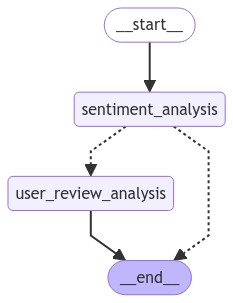

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from simple_colors import *

review = """The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain"""

user_input = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(user_input, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'overall_status': ''}
------ENTERING: SENTIMENT ANALYSIS NODE------
{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'sentiment_label': None, 'feedback_analysis': None, 'overall_status': ''}
--------
Sentiment Identified: [Mixed]
--------
{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'sentiment_label': 'Mixed', 'overall_status': ''}
------ENTERING: USER REVIEW ANALYSIS NODE------
{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pai

Based on the user review, here are the top reasons that did not work for the user:

1. **Initial Disinterest**:
   - The user mentioned walking out of the hall within 1 minute of the movie starting. This indicates that the beginning of the movie failed to capture their interest or attention.

2. **Inconsistent Engagement**:
   - The user returned to the hall within 5 minutes, suggesting a brief moment of reconsideration. However, this inconsistency in engagement shows that the movie did not maintain a compelling narrative or elements to keep the user consistently interested.

3. **Lack of Engagement Leading to Sleep**:
   - The user fell asleep during the movie. This is a strong indicator that the movie was not engaging or stimulating enough to keep the user awake and interested.

4. **Conflicting Emotions**:
   - The user mentioned "enjoyed with pain," which suggests a mixed sentiment. While there were moments of enjoyment, they were overshadowed by an overall sense of discomfort or dissatisfaction.

In summary, the movie failed to maintain the user's interest from the start, leading to disengagement and even sleep. The conflicting emotions of enjoyment and pain further highlight the mixed sentiment, indicating that while there were some positive aspects, they were not enough to overcome the negative experience.

{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'sentiment_label': 'Mixed', 'feedback_analysis': 'Based on the user review, here are the top reasons that did not work for the user:\n\n1. **Initial Disinterest**:\n   - The user mentioned walking out of the hall within 1 minute of the movie starting. This indicates that the beginning of the movie failed to capture their interest or attention.\n\n2. **Inconsistent Engagement**:\n   - The user returned to the hall within 5 minutes, suggesting a brief moment of reconsideration. However, this inconsistency in engagement shows that the movie did not maintain a compelling narrative or elements to keep the user consistently interested.\n\n3. **Lack of Engagement Leading to Sleep**:\n   - The user fell asleep during the movie. This is a strong indicator that the movie was not engaging or stimulating enough to keep th

In [ ]:
from simple_colors import *

review = """Buckle up for a roller-coaster ride through cinematic chaos! The story idea is an absolute gem, brimming with potential, and the characters are nothing short of a casting director's dream-each one brimming with pizzazz and personality. But alas, their development seems to have been left in the microwave a bit too long, coming out half-baked.

The screenplay? It's flatter than a week-old soda. Though, I must admit, it does have its fizz in a few key moments, like the interval and the climax.

Dialogues? Let's just say they won't be winning any literary awards.

Now, onto the comedy-it's the kind that instead of tickling your funny bone, it goes straight for the jugular, and not in a good way. The world-building feels like it was put together with duct tape and imagination, lacking the immersive magic we hoped for.

But let's talk about the legendary Amitabh Bachchan, who is stellar as always.

Prabhas gives it his all, bless his heart.

Kamal Hassan makes a brief yet dazzling appearance, hinting at more brilliance in the next instalment.

Saswata Chatterjee? He brings his A-game, no doubt about it.

Deepika Padukone looks fine and delivers a decent performance, and her Telugu dubbing is better than that in the trailer.

Disha Patani is scorching enough to set the screen on fire in her limited screen time.

The rest of the cast, including Pashupati, Shobhana and Rajendra Prasad put in decent efforts. However, the film is sprinkled with cameos like confetti at a surprise party-most of which are more of a head-scratcher than a treat.

The action scenes? They're as disappointing as a soggy French fry.

Cinematography is serviceable, background music hits the right notes, but the songs miss the mark.

Production values are respectable, but direction sails somewhere in the middling seas of mediocrity.

Some VFX are eye-poppingly good, though.

Overall, it's a mixed bag of delights and letdowns-a cinematic hotpot where the ingredients are only half-cooked. Enjoy it for what it is, but don't be surprised if you leave the theater feeling a little unsatisfied"""

user_input = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(user_input, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': "Buckle up for a roller-coaster ride through cinematic chaos! The story idea is an absolute gem, brimming with potential, and the characters are nothing short of a casting director's dream-each one brimming with pizzazz and personality. But alas, their development seems to have been left in the microwave a bit too long, coming out half-baked.\n\nThe screenplay? It's flatter than a week-old soda. Though, I must admit, it does have its fizz in a few key moments, like the interval and the climax.\n\nDialogues? Let's just say they won't be winning any literary awards.\n\nNow, onto the comedy-it's the kind that instead of tickling your funny bone, it goes straight for the jugular, and not in a good way. The world-building feels like it was put together with duct tape and imagination, lacking the immersive magic we hoped for.\n\nBut let's talk about the legendary Amitabh Bachchan, who is stellar as always.\n\nPrabhas gives it his all, bless his heart.\n\nKamal Hassan makes a 

Based on the user review, here are the top reasons that did not work for the user, along with justifications for each point:

1. **Character Development**:
   - **Justification**: The user mentions that the characters, despite having great potential and being well-cast, come out "half-baked." This suggests that the characters were not fully developed or explored, leaving the audience wanting more depth and growth.

2. **Screenplay**:
   - **Justification**: The screenplay is described as "flatter than a week-old soda," indicating that it lacked engagement and excitement. Although there were a few key moments that stood out, the overall narrative failed to maintain a consistent level of interest.

3. **Dialogues**:
   - **Justification**: The dialogues are criticized for not being noteworthy, with the user stating they "won't be winning any literary awards." This implies that the dialogues were uninspired and did not contribute significantly to the film's impact.

4. **Comedy**:
   - **Justification**: The comedy is described as missing the mark, with the user stating it "goes straight for the jugular, and not in a good way." This suggests that the humor was either too forced or inappropriate, failing to elicit the intended laughs.

5. **World-Building**:
   - **Justification**: The world-building is likened to being "put together with duct tape and imagination," indicating that it lacked coherence and the immersive quality that makes a fictional world believable and engaging.

6. **Action Scenes**:
   - **Justification**: The action scenes are compared to "a soggy French fry," implying they were underwhelming and did not deliver the excitement or intensity expected from such sequences.

7. **Songs**:
   - **Justification**: While the background music is praised, the songs are said to "miss the mark," suggesting that they did not resonate with the user or enhance the overall experience of the film.

8. **Direction**:
   - **Justification**: The direction is described as "sailing somewhere in the middling seas of mediocrity," indicating that it was neither particularly bad nor exceptionally good, but rather average and unremarkable.

9. **Cameos**:
   - **Justification**: The numerous cameos are compared to "confetti at a surprise party," with most being "more of a head-scratcher than a treat." This suggests that the cameos felt unnecessary or confusing, rather than adding value to the film.

Overall, while the review acknowledges some positive aspects, such as the performances of certain actors and some good VFX, the numerous shortcomings in character development, screenplay, dialogues, comedy, world-building, action scenes, songs, direction, and the use of cameos contribute to a mixed sentiment, leaving the user feeling somewhat unsatisfied.

{'user_review': "Buckle up for a roller-coaster ride through cinematic chaos! The story idea is an absolute gem, brimming with potential, and the characters are nothing short of a casting director's dream-each one brimming with pizzazz and personality. But alas, their development seems to have been left in the microwave a bit too long, coming out half-baked.\n\nThe screenplay? It's flatter than a week-old soda. Though, I must admit, it does have its fizz in a few key moments, like the interval and the climax.\n\nDialogues? Let's just say they won't be winning any literary awards.\n\nNow, onto the comedy-it's the kind that instead of tickling your funny bone, it goes straight for the jugular, and not in a good way. The world-building feels like it was put together with duct tape and imagination, lacking the immersive magic we hoped for.\n\nBut let's talk about the legendary Amitabh Bachchan, who is stellar as always.\n\nPrabhas gives it his all, bless his heart.\n\nKamal Hassan makes a 

# Branching

In [ ]:
import os
import json
from openai import AzureOpenAI
from langchain.tools import tool
from langchain.agents import AgentType
from IPython.display import display, Image
from langchain.chat_models import ChatOpenAI
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.agents import Tool, AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate


import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")

GPT4o_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

EAST_US_2_API_KEY = os.getenv('east_us2_API_KEY')
EAST_US_2_API_BASE = os.getenv('east_us2_API_BASE')

AUS_API_KEY = os.getenv('australia_API_KEY')
AUS_API_BASE = os.getenv('australia_API_BASE')

llm = AzureChatOpenAI(
        azure_endpoint=EAST_US_2_API_BASE,
        api_version=API_VERSION,
        azure_deployment=GPT4o_DEPLOYMENT_NAME,
        openai_api_key=EAST_US_2_API_KEY,
        temperature=0)

image_llm = AzureOpenAI(
        azure_endpoint=AUS_API_BASE,
        api_version=API_VERSION,
        api_key=AUS_API_KEY)

In [ ]:
def create_web_search_agent(llm: ChatOpenAI, tools: list, system_prompt: str, verbose=False):
    """Helper function for creating agent executor"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="input"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return executor


# Create a tool to processes content from a webpage
@tool("generate_image", return_direct=False)
def generate_image(prompt) -> str:
    """
    Use this tool to generate the images for the given prompt.

    Args:
      prompt (str): Text description of image that you wanted to generate

    Returns:
      image_url (str): The URL created with generated image.
    """
    result = image_llm.images.generate(
        model="fra-copilot-dalle",
        prompt=prompt,
        n=1
    )
    image_url = json.loads(result.model_dump_json())['data'][0]['url']
    display(Image(url=image_url))
    display(Markdown(prompt))
    display(Markdown("----------------------"))
    return image_url


def create_story_board_creation_agent(llm, verbose=False):
    """Helper function for creating agent executor"""
    tools = [generate_image]
    story_board_image_generate_prompt = """#Context: You are an autonomous AI image generation agent designed to create unique and high-quality images based on user-provided prompts. Your task is to interpret the given prompt creatively and generate an image that accurately reflects the described scene or concept.

    #Objective: Generate images for storyboard creation for advertisements by adhering to the below guidelines

    #Guidelines:

    1. Receive and Process Multi-Scene Prompts:
        - The prompt will contain multiple scenes.
        - Each scene will include the following components: Visual, Sound, Camera Transition, Action, Close-Up, Text on Screen.
        - Also the prompt consists of Justification with Relatability, Emotional Appeal, Visual Aesthetics, Clear Message.

    2. Iterative Scene Processing:
        - For each scene, extract the Visual, Sound, Camera Transition, Action, Close-Up, and Text on Screen elements.
        - Generate an image that accurately represents the combined essence of these elements.

    3. Image Generation Guidelines:
        - Visual: Focus on the main visual elements described. This includes the setting, objects, and characters.
        - Sound: Although sound is auditory, interpret and reflect the mood or atmosphere it conveys visually.
        - Camera Transition: Reflect the specified camera transitions (e.g., zoom, pan, tilt) to capture the dynamic aspect of the scene.
        - Action: Ensure the image captures the described action, emphasizing motion or interaction where applicable.
        - Close-Up: Highlight any specified close-up elements to focus on details or emotions.
        - Text on Screen: Integrate the provided text into the image, ensuring it complements the visual narrative.
        - Make sure you include the and follow Justification mentioned in Guidelines #1 in all the images that you generate

    4. Consistency and Continuity:
        - Maintain consistent color palettes, mood, and charecters
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", story_board_image_generate_prompt),
        MessagesPlaceholder(variable_name="input"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return agent_executor


In [ ]:
import functools, operator
from typing import Annotated
from langchain.tools import tool
from IPython.display import Markdown
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.tools.retriever import create_retriever_tool
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, AnyMessage


class State(TypedDict):
    theme: str
    concept: str
    screenplay_1: str
    screenplay_2: str
    screenplay_winner: int
    story_board: str
    overall_status: Annotated[str, operator.add]


# Create a tool to search the internet using TavilySearchAPI
def get_tavily_search_retriever():
    retriever = TavilySearchAPIRetriever(k=7)
    retriever_description = "Use this tool when you need to answer questions related to current events and latest happenings or anything related to the user ask"
    retrieve_tool = create_retriever_tool(retriever=retriever, name="internet_search", description=retriever_description)
    return retrieve_tool


def ad_concept_creation_node(state):
    print("------ENTERING: AD CONCEPT CREATION NODE------")
    writer_prompt = """You are an intelligent advertisemment concept creator for any given theme.
                        Your job is to generate a concept for the given theme and justify it.
                        Note: You can search over internet for the references but make sure the concept is fresh and novel."""
    # Tool to run python codes in
    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    concept = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**CONCEPT 1:**"""))
    display(Markdown(f"""<font color="navy">{concept['output']}</font>"""))

    return {"concept": concept['output']}


def screen_play_creation_node_1(state):
    print("------ENTERING: SCRENNPLAY CREATION NODE 1: In SS Rajamouli Style------")
    writer_prompt = f"""#Context: You are an autonomous AI screenplay creation agent designed to create a screenplay for any given advertisement concept.

                        #Objective: Generate a unique, fresh, and novel screenplay for an advertisement concept.

                        #Guidelines:

                        1. Style and Inspiration:

                          - The screenplay should be influenced by the style of SS Rajamouli, a renowned Indian cinema director known for his epic storytelling, grand visuals, and emotional depth.
                          - Emulate the cinematic experience seen in Rajamouli's films, focusing on strong character development, dramatic plot twists, and visually captivating scenes.

                        2. Content Compliance:

                          - Ensure the screenplay adheres to all content guidelines and does not include any content violations.
                          - Avoid themes or depictions that could be considered offensive, inappropriate, or culturally insensitive.

                        3. Screenplay Structure:

                          - Title: [Provide a captivating title for the ad concept]
                          - Genre: [Specify the genre, e.g., fantasy, action, drama, etc.]
                          - Setting: Describe the primary locations and time periods where the story takes place.
                          - Characters: Introduce the main characters, detailing their roles, personalities, and relationships.
                          - Plot Overview: Provide a brief summary of the story arc, including the main conflict and resolution.
                          - Scenes: Outline the key scenes in the screenplay, ensuring a logical flow and narrative progression.
                          - Dialogue: Craft engaging and authentic dialogue that reflects the characters' personalities and advances the plot.

                        4. Scene Breakdown:

                          a. Opening Scene:

                            - Visuals: Describe the setting, atmosphere, and key visual elements.
                            - Sound: Indicate background music, sound effects, and any important audio cues.
                            - Action: Detail the actions and movements of characters within the scene.
                            - Camera Transition: Specify camera angles, movements, and transitions.
                            - Close-Up: Highlight any close-up shots that emphasize emotions or significant details.
                            - Text on Screen: Include any text that appears on screen, such as titles, captions, or subtitles.

                          b. Middle Scenes:
                            - Follow the same structure as the opening scene for each subsequent scene, ensuring continuity and coherence in the narrative.

                          c. Climactic Scene:
                            - Build up to the climax with heightened tension, dramatic reveals, and intense action.

                          d. Ending Scene:
                            - Resolve the main conflict, wrap up loose ends, and provide a satisfying conclusion.

                        Additional Notes:

                          - Maintain the color palette, mood, and character consistency throughout the screenplay.
                          - Incorporate Rajamouli's signature elements such as heroic feats, moral dilemmas, and visually stunning sequences.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.

                        Given Theme: {state['theme']}
                        Given Concept: {state['concept']}"""

    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    screenplay = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**SCREENPLAY 1: In SS Rajamouli Style**"""))
    display(Markdown(f"""<font color="blue">{screenplay['output']}</font>"""))
    return {"screenplay_1": screenplay['output']}


def screen_play_creation_node_2(state):
    print("------ENTERING: SCRENNPLAY CREATION NODE 2: In Shankar Style------")
    writer_prompt = f"""#Context: You are an autonomous AI screenplay creation agent designed to create a screenplay for any given advertisement concept.

                        #Objective: Generate a unique, fresh, and novel screenplay for an advertisement concept.

                        #Guidelines:

                        1. Style and Inspiration:

                          - The screenplay should be influenced by the style of Shankar, a renowned Indian cinema director known for his grandiose visuals, intricate storytelling, and socially relevant themes.
                          -  The screenplay should reflect Shankar's cinematic experience, including high-impact visuals, compelling narratives, and dramatic sequences. Emphasize strong character development, elaborate sets, and emotional depth.

                        2. Content Compliance:

                          - Ensure the screenplay adheres to all content guidelines and does not include any content violations.
                          - Avoid themes or depictions that could be considered offensive, inappropriate, or culturally insensitive.

                        3. Screenplay Structure:

                          - Title: [Provide a captivating title for the ad concept]
                          - Genre: [Specify the genre, e.g., fantasy, action, drama, etc.]
                          - Setting: Describe the primary locations and time periods where the story takes place.
                          - Characters: Introduce the main characters, detailing their roles, personalities, and relationships.
                          - Plot Overview: Provide a brief summary of the story arc, including the main conflict and resolution.
                          - Scenes: Outline the key scenes in the screenplay, ensuring a logical flow and narrative progression.
                          - Dialogue: Craft engaging and authentic dialogue that reflects the characters' personalities and advances the plot.

                        4. Scene Breakdown:

                          a. Opening Scene:

                            - Visuals: Describe the setting, atmosphere, and key visual elements.
                            - Sound: Indicate background music, sound effects, and any important audio cues.
                            - Action: Detail the actions and movements of characters within the scene.
                            - Camera Transition: Specify camera angles, movements, and transitions.
                            - Close-Up: Highlight any close-up shots that emphasize emotions or significant details.
                            - Text on Screen: Include any text that appears on screen, such as titles, captions, or subtitles.

                          b. Middle Scenes:
                            - Follow the same structure as the opening scene for each subsequent scene, ensuring continuity and coherence in the narrative.

                          c. Climactic Scene:
                            - Build up to the climax with heightened tension, dramatic reveals, and intense action.

                          d. Ending Scene:
                            - Resolve the main conflict, wrap up loose ends, and provide a satisfying conclusion.

                        Additional Notes:

                          - Maintain the color palette, mood, and character consistency throughout the screenplay.
                          - Incorporate Shankar's signature elements such as grandiose visuals, intricate storytelling, and socially relevant themes.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.

                        Given Theme: {state['theme']}
                        Given Concept: {state['concept']}"""

    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    screenplay = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**SCREENPLAY 2: In Shankar Style:**"""))
    display(Markdown(f"""<font color="green">{screenplay['output']}</font>"""))
    return {"screenplay_2": screenplay['output']}


def screenplay_evaluation_node(state):
    display(Markdown("---------------------------------"))
    user_input = int(input("Which screenplay did you like and proceed with?\n\n1. Rajamouli \n2. Shankar \n\nPlease enter 1 or 2!"))
    screenplay_winner = f"screenplay_{user_input}"
    display(Markdown(f"""**SCREENPLAY WINNER:** <font color="red">[{screenplay_winner}]</font>"""))
    display(Markdown(f"""<font color="red">{state[screenplay_winner]}</font>"""))
    return {"screenplay_winner": screenplay_winner}


def story_board_creation_node(state):
    print("------ENTERING: STORY BOARD CREATION NODE------")

    story_board_agent = create_story_board_creation_agent(llm, verbose=False)
    story_board = story_board_agent.invoke({"input": [HumanMessage(content=state[state['screenplay_winner']])]})

    return {"story_board": story_board['output']}


# Define a graph
workflow = StateGraph(State)

# workflow.add_node("topic_modelling_node", topic_modelling_node)
workflow.add_node("ad_concept_creation_node", ad_concept_creation_node)
workflow.add_node("screen_play_creation_in_rajamouli_style", screen_play_creation_node_1)
workflow.add_node("screen_play_creation_in_shankar_style", screen_play_creation_node_2)
workflow.add_node("screenplay_evaluation_node", screenplay_evaluation_node)
workflow.add_node("story_board_creation_node", story_board_creation_node)


workflow.set_entry_point("ad_concept_creation_node")

workflow.add_edge("ad_concept_creation_node", "screen_play_creation_in_rajamouli_style")
workflow.add_edge("ad_concept_creation_node", "screen_play_creation_in_shankar_style")

workflow.add_edge("screen_play_creation_in_rajamouli_style", "screenplay_evaluation_node")
workflow.add_edge("screen_play_creation_in_shankar_style", "screenplay_evaluation_node")

workflow.add_edge("screenplay_evaluation_node", "story_board_creation_node")

workflow.set_finish_point("story_board_creation_node")

app = workflow.compile()

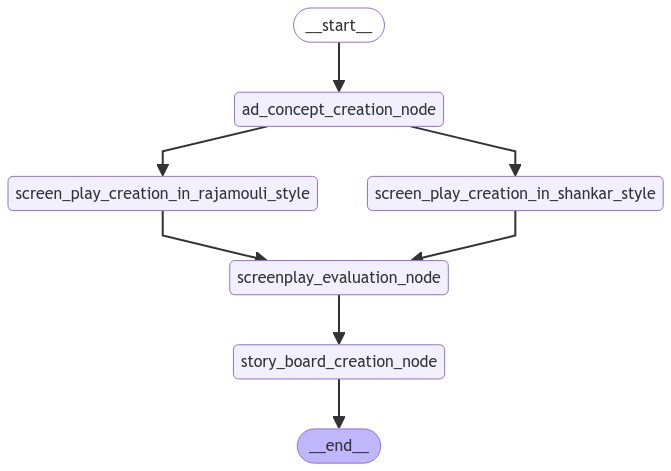

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from simple_colors import *

graph_input = {"theme": """Create an ad for the volkswagen taigun car"""}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(graph_input, thread, stream_mode="values"):
    # print(cyan(output, ['bold']))
    pass

------ENTERING: CONCEPT CREATION NODE 1------


**CONCEPT 1:**

<font color="blue">### Ad Concept: "Unleash Your Drive with the Volkswagen Taigun"

#### Visuals:
1. **Opening Scene**: A bustling cityscape at dawn, transitioning to serene countryside roads.
2. **Close-Up Shots**: The sleek exterior of the Volkswagen Taigun, highlighting its modern design and premium finishes.
3. **Interior Shots**: Showcasing the luxurious and tech-savvy interior, with a focus on the infotainment system, comfortable seating, and spaciousness.
4. **Action Shots**: The Taigun navigating through city traffic effortlessly, then transitioning to smooth, powerful drives on open highways and rugged terrains.
5. **Family and Friends**: Scenes of a family enjoying a road trip, friends on an adventure, and a professional heading to a business meeting, all in the Taigun.

#### Script:
**Narrator (Voiceover)**: 
"Introducing the Volkswagen Taigun – where passion meets performance."

**Scene 1**: [Cityscape at dawn]
"Designed for the ambitious and the energetic, the Taigun is your perfect companion in the urban jungle."

**Scene 2**: [Close-up of the exterior]
"With its bold design and premium finishes, the Taigun stands out, making a statement wherever you go."

**Scene 3**: [Interior shots]
"Step inside to experience luxury and innovation. The Taigun's advanced infotainment system and spacious interiors ensure every journey is a pleasure."

**Scene 4**: [Action shots on different terrains]
"Powered by the robust 1.5 TSI engine, the Taigun delivers unmatched performance, whether you're navigating city streets or exploring the great outdoors."

**Scene 5**: [Family and friends enjoying the ride]
"Built for those who are vibrant, upwardly mobile, and confident, the Taigun adapts to your lifestyle, making every drive memorable."

**Closing Scene**: [Taigun driving into the sunset]
"Unleash your drive with the Volkswagen Taigun. Where will it take you next?"

**Narrator (Voiceover)**: 
"Volkswagen Taigun – Drive Your Ambition."

#### Justification:
1. **Target Audience Alignment**: The ad focuses on the Taigun's target audience – passionate, ambitious, energetic, vibrant, upwardly mobile, and confident individuals. By showcasing different scenarios (urban driving, family trips, adventures), it appeals to a broad spectrum of potential buyers.
2. **Feature Highlighting**: The ad emphasizes the Taigun's key features – modern design, premium interior, powerful engine options, and advanced technology. This aligns with the latest updates and features of the 2023 model.
3. **Emotional Connection**: By incorporating scenes of family and friends, the ad creates an emotional connection, portraying the Taigun as a versatile vehicle that enhances life's moments.
4. **Brand Positioning**: The tagline "Drive Your Ambition" reinforces Volkswagen's brand positioning, encouraging viewers to see the Taigun as a vehicle that supports and enhances their ambitions and lifestyle.

This concept ensures that the Volkswagen Taigun is presented as a dynamic, stylish, and versatile SUV, perfectly suited for the modern, ambitious driver.</font>

------ENTERING: SCRENNPLAY CREATION NODE 1------------ENTERING: SCRENNPLAY CREATION NODE 2------



**SCREENPLAY 1: In SS Rajamouli Style**

<font color="blue">### Title: "Unleash Your Drive with the Volkswagen Taigun"

### Genre: Action-Adventure Drama

### Setting:
- **Primary Locations**: A bustling modern city, serene countryside roads, rugged mountain terrains, and a picturesque coastal highway.
- **Time Period**: Present day, with scenes transitioning from dawn to dusk.

### Characters:
- **Arjun**: A dynamic young professional, ambitious and energetic, in his early 30s.
- **Maya**: Arjun's adventurous and spirited wife, in her late 20s.
- **Rohan**: Arjun's best friend, a tech-savvy and fun-loving individual, in his early 30s.
- **Aarav**: Arjun and Maya's curious and playful 5-year-old son.

### Plot Overview:
Arjun, a driven professional, balances his demanding career with his love for adventure and family. The Volkswagen Taigun becomes his trusted companion, seamlessly adapting to his urban lifestyle, family road trips, and thrilling escapades. The ad showcases the Taigun's versatility, luxury, and performance, culminating in a powerful message about ambition and exploration.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, transitioning to serene countryside roads.
- **Sound**: Energetic background music with the sounds of the city waking up.
- **Action**: Arjun, dressed in a sharp suit, steps out of his apartment building and heads towards his Volkswagen Taigun parked on the street.
- **Camera Transition**: Aerial shot of the city transitioning to a close-up of the Taigun's sleek exterior.
- **Close-Up**: The Taigun's modern design and premium finishes.
- **Text on Screen**: "Introducing the Volkswagen Taigun – where passion meets performance."

#### Middle Scenes:

##### Scene 1:
- **Visuals**: Arjun driving through the city, effortlessly navigating traffic.
- **Sound**: Upbeat music with city sounds in the background.
- **Action**: Arjun glances at the infotainment system, which displays navigation and music options.
- **Camera Transition**: Interior shots showcasing the luxurious and tech-savvy interior.
- **Close-Up**: The infotainment system, comfortable seating, and spaciousness.
- **Text on Screen**: "Designed for the ambitious and the energetic, the Taigun is your perfect companion in the urban jungle."

##### Scene 2:
- **Visuals**: The Taigun driving on open highways and rugged terrains.
- **Sound**: Powerful engine sounds and dynamic music.
- **Action**: Arjun and Maya, with Aarav in the backseat, enjoying a family road trip. The Taigun smoothly transitions from highways to rugged mountain roads.
- **Camera Transition**: Wide shots of the car on different terrains, close-ups of the family enjoying the ride.
- **Close-Up**: The Taigun's robust 1.5 TSI engine and its performance on various terrains.
- **Text on Screen**: "Powered by the robust 1.5 TSI engine, the Taigun delivers unmatched performance, whether you're navigating city streets or exploring the great outdoors."

##### Scene 3:
- **Visuals**: Arjun and Rohan on an adventure, driving along a picturesque coastal highway.
- **Sound**: Energetic and adventurous music.
- **Action**: The friends laugh and enjoy the drive, stopping at a scenic viewpoint.
- **Camera Transition**: Drone shots of the coastal highway, close-ups of the friends and the car.
- **Close-Up**: The Taigun's exterior against the backdrop of the ocean.
- **Text on Screen**: "Built for those who are vibrant, upwardly mobile, and confident, the Taigun adapts to your lifestyle, making every drive memorable."

#### Climactic Scene:
- **Visuals**: The Taigun driving into the sunset, with the city skyline in the background.
- **Sound**: Inspirational and uplifting music.
- **Action**: Arjun, Maya, and Aarav, with Rohan, all together in the car, sharing a moment of joy and contentment.
- **Camera Transition**: Wide shot of the car driving into the sunset, close-ups of the family and friends.
- **Close-Up**: The Taigun's logo and tagline.
- **Text on Screen**: "Unleash your drive with the Volkswagen Taigun. Where will it take you next?"

#### Ending Scene:
- **Visuals**: The Taigun parked at a scenic viewpoint, with the family and friends enjoying the view.
- **Sound**: Soft, serene music.
- **Action**: The group steps out of the car, taking in the beautiful scenery.
- **Camera Transition**: Slow pan from the car to the group, capturing their smiles and the stunning view.
- **Close-Up**: The Taigun's logo and the tagline.
- **Text on Screen**: "Volkswagen Taigun – Drive Your Ambition."

### Additional Notes:
- **Color Palette**: Vibrant and dynamic colors for city scenes, warm and earthy tones for countryside and mountain scenes, and cool, serene hues for coastal scenes.
- **Mood**: Energetic and ambitious in the city, adventurous and free-spirited on the road, and warm and joyful with family and friends.
- **Character Consistency**: Arjun's ambition and energy, Maya's adventurous spirit, Rohan's tech-savviness and fun-loving nature, and Aarav's curiosity and playfulness are consistently portrayed throughout the ad.
- **Signature Elements**: Heroic feats (navigating different terrains), moral dilemmas (balancing work and family), and visually stunning sequences (driving through diverse landscapes).

This screenplay ensures that the Volkswagen Taigun is presented as a dynamic, stylish, and versatile SUV, perfectly suited for the modern, ambitious driver.</font>

**SCREENPLAY 2: In Shankar Style:**

<font color="green">### Title: "Unleash Your Drive with the Volkswagen Taigun"

### Genre: Action-Drama

### Setting:
- **Primary Locations**: A bustling metropolitan city, serene countryside roads, rugged mountain terrains, and a picturesque coastal highway.
- **Time Period**: Present day, with scenes transitioning from dawn to dusk.

### Characters:
- **Arjun**: A dynamic young professional in his early 30s, ambitious and energetic.
- **Priya**: Arjun's supportive and adventurous wife, in her late 20s.
- **Rohan**: Arjun's best friend, a tech-savvy and fun-loving individual.
- **Aarav**: Arjun and Priya's 5-year-old son, curious and playful.

### Plot Overview:
Arjun, a driven professional, balances his demanding career with his love for adventure and family. The Volkswagen Taigun becomes his trusted companion, seamlessly adapting to his urban lifestyle, family road trips, and thrilling escapades with friends. The ad showcases the Taigun's versatility, luxury, and performance, culminating in a powerful message about ambition and drive.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, transitioning to serene countryside roads.
- **Sound**: Energetic background music with the sounds of the city waking up.
- **Action**: Arjun, dressed in a sharp suit, steps out of his apartment building and heads towards his Volkswagen Taigun parked on the street.
- **Camera Transition**: Aerial shot of the city, zooming in on Arjun and the Taigun.
- **Close-Up**: The sleek exterior of the Volkswagen Taigun, highlighting its modern design and premium finishes.
- **Text on Screen**: "Introducing the Volkswagen Taigun – where passion meets performance."

#### Scene 1: Urban Jungle
- **Visuals**: Arjun driving through the bustling city, effortlessly navigating traffic.
- **Sound**: Upbeat music with city sounds in the background.
- **Action**: Arjun skillfully maneuvers the Taigun through busy streets, arriving at his office.
- **Camera Transition**: Smooth tracking shots of the Taigun in motion.
- **Close-Up**: Arjun's confident expression as he parks the car.
- **Text on Screen**: "Designed for the ambitious and the energetic, the Taigun is your perfect companion in the urban jungle."

#### Scene 2: Bold Design
- **Visuals**: Close-up shots of the Taigun's exterior, focusing on its bold design and premium finishes.
- **Sound**: Subtle, sophisticated background music.
- **Action**: Arjun and Priya admire the car's design before getting in.
- **Camera Transition**: Slow pans and zooms to highlight the car's features.
- **Close-Up**: The Taigun's sleek lines and stylish details.
- **Text on Screen**: "With its bold design and premium finishes, the Taigun stands out, making a statement wherever you go."

#### Scene 3: Luxurious Interior
- **Visuals**: Interior shots showcasing the luxurious and tech-savvy interior.
- **Sound**: Soft, elegant music with the sound of the infotainment system starting up.
- **Action**: Arjun and Priya enjoy the comfortable seating and advanced infotainment system.
- **Camera Transition**: Smooth transitions between different interior features.
- **Close-Up**: The infotainment system, comfortable seats, and spacious interiors.
- **Text on Screen**: "Step inside to experience luxury and innovation. The Taigun's advanced infotainment system and spacious interiors ensure every journey is a pleasure."

#### Scene 4: Performance on Different Terrains
- **Visuals**: The Taigun navigating through city traffic, open highways, and rugged terrains.
- **Sound**: Dynamic music with the sound of the engine revving.
- **Action**: Arjun drives the Taigun through various terrains, showcasing its performance.
- **Camera Transition**: Fast-paced cuts and dynamic angles to emphasize speed and power.
- **Close-Up**: The Taigun's wheels and engine in action.
- **Text on Screen**: "Powered by the robust 1.5 TSI engine, the Taigun delivers unmatched performance, whether you're navigating city streets or exploring the great outdoors."

#### Scene 5: Family and Friends
- **Visuals**: Scenes of Arjun, Priya, Rohan, and Aarav enjoying a road trip and adventure.
- **Sound**: Joyful, uplifting music with laughter and conversation.
- **Action**: The family and friends enjoy various activities, from a picnic to a beach drive.
- **Camera Transition**: Warm, inviting shots of the group having fun.
- **Close-Up**: Smiling faces, the Taigun's spacious interior, and the scenic surroundings.
- **Text on Screen**: "Built for those who are vibrant, upwardly mobile, and confident, the Taigun adapts to your lifestyle, making every drive memorable."

#### Climactic Scene:
- **Visuals**: The Taigun driving through a dramatic mountain pass at sunset.
- **Sound**: Intense, inspiring music building up to a crescendo.
- **Action**: Arjun and Priya share a moment of awe as they reach the peak, overlooking a breathtaking view.
- **Camera Transition**: Sweeping aerial shots and close-ups of their expressions.
- **Close-Up**: The Taigun's emblem shining in the golden light.
- **Text on Screen**: "Unleash your drive with the Volkswagen Taigun. Where will it take you next?"

#### Ending Scene:
- **Visuals**: The Taigun driving into the sunset, leaving a trail of dust.
- **Sound**: Soothing, triumphant music fading out.
- **Action**: The car disappears into the horizon, symbolizing endless possibilities.
- **Camera Transition**: Fade to black.
- **Text on Screen**: "Volkswagen Taigun – Drive Your Ambition."

### Additional Notes:
- **Color Palette**: Warm, vibrant colors for the family and adventure scenes; cool, sophisticated tones for the urban and interior shots.
- **Mood**: Energetic, inspiring, and emotionally resonant.
- **Character Consistency**: Arjun's ambition and drive, Priya's support and adventurous spirit, Rohan's fun-loving nature, and Aarav's curiosity are consistently portrayed throughout the ad.
- **Signature Elements**: Grandiose visuals, intricate storytelling, and a socially relevant theme of ambition and drive.

This screenplay ensures that the Volkswagen Taigun is presented as a dynamic, stylish, and versatile SUV, perfectly suited for the modern, ambitious driver.</font>

Which screenplay did you like and proceed with? Is it 1 or 2?1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

<font color="red">### Title: "Unleash Your Drive with the Volkswagen Taigun"

### Genre: Action-Adventure Drama

### Setting:
- **Primary Locations**: A bustling modern city, serene countryside roads, rugged mountain terrains, and a picturesque coastal highway.
- **Time Period**: Present day, with scenes transitioning from dawn to dusk.

### Characters:
- **Arjun**: A dynamic young professional, ambitious and energetic, in his early 30s.
- **Maya**: Arjun's adventurous and spirited wife, in her late 20s.
- **Rohan**: Arjun's best friend, a tech-savvy and fun-loving individual, in his early 30s.
- **Aarav**: Arjun and Maya's curious and playful 5-year-old son.

### Plot Overview:
Arjun, a driven professional, balances his demanding career with his love for adventure and family. The Volkswagen Taigun becomes his trusted companion, seamlessly adapting to his urban lifestyle, family road trips, and thrilling escapades. The ad showcases the Taigun's versatility, luxury, and performance, culminating in a powerful message about ambition and exploration.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, transitioning to serene countryside roads.
- **Sound**: Energetic background music with the sounds of the city waking up.
- **Action**: Arjun, dressed in a sharp suit, steps out of his apartment building and heads towards his Volkswagen Taigun parked on the street.
- **Camera Transition**: Aerial shot of the city transitioning to a close-up of the Taigun's sleek exterior.
- **Close-Up**: The Taigun's modern design and premium finishes.
- **Text on Screen**: "Introducing the Volkswagen Taigun – where passion meets performance."

#### Middle Scenes:

##### Scene 1:
- **Visuals**: Arjun driving through the city, effortlessly navigating traffic.
- **Sound**: Upbeat music with city sounds in the background.
- **Action**: Arjun glances at the infotainment system, which displays navigation and music options.
- **Camera Transition**: Interior shots showcasing the luxurious and tech-savvy interior.
- **Close-Up**: The infotainment system, comfortable seating, and spaciousness.
- **Text on Screen**: "Designed for the ambitious and the energetic, the Taigun is your perfect companion in the urban jungle."

##### Scene 2:
- **Visuals**: The Taigun driving on open highways and rugged terrains.
- **Sound**: Powerful engine sounds and dynamic music.
- **Action**: Arjun and Maya, with Aarav in the backseat, enjoying a family road trip. The Taigun smoothly transitions from highways to rugged mountain roads.
- **Camera Transition**: Wide shots of the car on different terrains, close-ups of the family enjoying the ride.
- **Close-Up**: The Taigun's robust 1.5 TSI engine and its performance on various terrains.
- **Text on Screen**: "Powered by the robust 1.5 TSI engine, the Taigun delivers unmatched performance, whether you're navigating city streets or exploring the great outdoors."

##### Scene 3:
- **Visuals**: Arjun and Rohan on an adventure, driving along a picturesque coastal highway.
- **Sound**: Energetic and adventurous music.
- **Action**: The friends laugh and enjoy the drive, stopping at a scenic viewpoint.
- **Camera Transition**: Drone shots of the coastal highway, close-ups of the friends and the car.
- **Close-Up**: The Taigun's exterior against the backdrop of the ocean.
- **Text on Screen**: "Built for those who are vibrant, upwardly mobile, and confident, the Taigun adapts to your lifestyle, making every drive memorable."

#### Climactic Scene:
- **Visuals**: The Taigun driving into the sunset, with the city skyline in the background.
- **Sound**: Inspirational and uplifting music.
- **Action**: Arjun, Maya, and Aarav, with Rohan, all together in the car, sharing a moment of joy and contentment.
- **Camera Transition**: Wide shot of the car driving into the sunset, close-ups of the family and friends.
- **Close-Up**: The Taigun's logo and tagline.
- **Text on Screen**: "Unleash your drive with the Volkswagen Taigun. Where will it take you next?"

#### Ending Scene:
- **Visuals**: The Taigun parked at a scenic viewpoint, with the family and friends enjoying the view.
- **Sound**: Soft, serene music.
- **Action**: The group steps out of the car, taking in the beautiful scenery.
- **Camera Transition**: Slow pan from the car to the group, capturing their smiles and the stunning view.
- **Close-Up**: The Taigun's logo and the tagline.
- **Text on Screen**: "Volkswagen Taigun – Drive Your Ambition."

### Additional Notes:
- **Color Palette**: Vibrant and dynamic colors for city scenes, warm and earthy tones for countryside and mountain scenes, and cool, serene hues for coastal scenes.
- **Mood**: Energetic and ambitious in the city, adventurous and free-spirited on the road, and warm and joyful with family and friends.
- **Character Consistency**: Arjun's ambition and energy, Maya's adventurous spirit, Rohan's tech-savviness and fun-loving nature, and Aarav's curiosity and playfulness are consistently portrayed throughout the ad.
- **Signature Elements**: Heroic feats (navigating different terrains), moral dilemmas (balancing work and family), and visually stunning sequences (driving through diverse landscapes).

This screenplay ensures that the Volkswagen Taigun is presented as a dynamic, stylish, and versatile SUV, perfectly suited for the modern, ambitious driver.</font>

------ENTERING: STORY BOARD CREATION NODE------


A bustling cityscape at dawn, transitioning to serene countryside roads. Arjun, dressed in a sharp suit, steps out of his apartment building and heads towards his Volkswagen Taigun parked on the street. Aerial shot of the city transitioning to a close-up of the Taigun's sleek exterior. Close-up of the Taigun's modern design and premium finishes. Text on Screen: 'Introducing the Volkswagen Taigun – where passion meets performance.'

----------------------

Arjun driving through the city, effortlessly navigating traffic. Upbeat music with city sounds in the background. Arjun glances at the infotainment system, which displays navigation and music options. Interior shots showcasing the luxurious and tech-savvy interior. Close-up of the infotainment system, comfortable seating, and spaciousness. Text on Screen: 'Designed for the ambitious and the energetic, the Taigun is your perfect companion in the urban jungle.'

----------------------

The Taigun driving on open highways and rugged terrains. Powerful engine sounds and dynamic music. Arjun and Maya, with Aarav in the backseat, enjoying a family road trip. The Taigun smoothly transitions from highways to rugged mountain roads. Wide shots of the car on different terrains, close-ups of the family enjoying the ride. Close-up of the Taigun's robust 1.5 TSI engine and its performance on various terrains. Text on Screen: 'Powered by the robust 1.5 TSI engine, the Taigun delivers unmatched performance, whether you're navigating city streets or exploring the great outdoors.'

----------------------

Arjun and Rohan on an adventure, driving along a picturesque coastal highway. Energetic and adventurous music. The friends laugh and enjoy the drive, stopping at a scenic viewpoint. Drone shots of the coastal highway, close-ups of the friends and the car. Close-up of the Taigun's exterior against the backdrop of the ocean. Text on Screen: 'Built for those who are vibrant, upwardly mobile, and confident, the Taigun adapts to your lifestyle, making every drive memorable.'

----------------------

The Taigun driving into the sunset, with the city skyline in the background. Inspirational and uplifting music. Arjun, Maya, and Aarav, with Rohan, all together in the car, sharing a moment of joy and contentment. Wide shot of the car driving into the sunset, close-ups of the family and friends. Close-up of the Taigun's logo and tagline. Text on Screen: 'Unleash your drive with the Volkswagen Taigun. Where will it take you next?'

----------------------

The Taigun parked at a scenic viewpoint, with the family and friends enjoying the view. Soft, serene music. The group steps out of the car, taking in the beautiful scenery. Slow pan from the car to the group, capturing their smiles and the stunning view. Close-up of the Taigun's logo and the tagline. Text on Screen: 'Volkswagen Taigun – Drive Your Ambition.'

----------------------

In [ ]:
from simple_colors import *

graph_input = {"theme": """About the brand Rolex"""}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(graph_input, thread, stream_mode="values"):
    # print(cyan(output, ['bold']))
    pass

------ENTERING: CONCEPT CREATION NODE 1------
------ENTERING: CONCEPT CREATION NODE 2------


**CONCEPT 2:** <font color="green">### Advertisement Concept: "Rolex - Timeless Excellence"

#### Concept Overview:
The advertisement will focus on the rich history and pioneering spirit of Rolex, emphasizing its journey from a visionary idea to a symbol of timeless excellence. The campaign will highlight key milestones and innovations, showcasing Rolex as not just a watch, but a legacy of precision, durability, and luxury.

#### Visual Elements:
1. **Historical Montage**: A series of black-and-white images and short clips showing Hans Wilsdorf, the founder, working on early designs, the first Rolex workshop, and the initial models.
2. **Innovations in Action**: Transition to color visuals showcasing the Oyster, the first waterproof wristwatch, being tested under extreme conditions, and other iconic models like the Submariner and Daytona in various adventurous and luxurious settings.
3. **Modern Masterpieces**: Close-up shots of the latest Rolex models, highlighting their intricate craftsmanship and modern features.
4. **Global Recognition**: Scenes of famous personalities and events where Rolex watches have been worn, emphasizing its status as a global icon.

#### Narrative:
The voiceover will narrate the journey of Rolex, starting from its inception in 1905 by Hans Wilsdorf and Alfred Davis, through its relocation to Geneva, and its numerous innovations that have set industry standards. The narrative will emphasize the brand's commitment to excellence and its role in significant historical moments.

#### Tagline:
"Rolex - Timeless Excellence"

#### Justification:
1. **Historical Depth**: By showcasing the brand's rich history, the advertisement builds a narrative of trust and legacy, appealing to both long-time enthusiasts and new customers.
2. **Innovation and Quality**: Highlighting key innovations like the Oyster and iconic models reinforces Rolex's reputation for quality and pioneering spirit.
3. **Emotional Connection**: The use of historical and modern visuals creates an emotional connection, showing that owning a Rolex is not just about telling time, but being part of a legacy.
4. **Global Appeal**: Featuring global recognition and famous personalities wearing Rolex watches underscores its status as a symbol of success and luxury worldwide.

This concept leverages the powerful history and innovations of Rolex to create a compelling narrative that resonates with a wide audience, reinforcing the brand's position as a leader in the luxury watch market.</font>

**CONCEPT 1:** <font color="blue">### Advertisement Concept for Rolex: "Timeless Legacy"

#### Concept Overview:
The advertisement will focus on the rich history and pioneering spirit of Rolex, emphasizing its journey from a visionary idea to a symbol of timeless excellence. The campaign will highlight key milestones and innovations that have defined Rolex, showcasing the brand's commitment to precision, durability, and elegance.

#### Visual Elements:
1. **Historical Montage**: The ad will open with a montage of black-and-white images and footage from the early 1900s, showing Hans Wilsdorf and the early days of Rolex. This will transition into colorful, modern-day scenes, illustrating the brand's evolution over more than a century.

2. **Iconic Watches**: Close-up shots of iconic Rolex models, such as the Oyster, Submariner, and Daytona, will be interspersed throughout the ad. Each watch will be shown in different settings, from deep-sea diving to high-stakes racing, highlighting their versatility and durability.

3. **Innovative Spirit**: Scenes of watchmakers at work in Rolex's Geneva headquarters, showcasing the meticulous craftsmanship and cutting-edge technology that go into every timepiece. This will be paired with historical footage of Rolex's pioneering achievements, such as the first waterproof wristwatch and the first wristwatch with an automatically changing date on the dial.

4. **Enduring Symbol**: The ad will feature the iconic Rolex crown logo, emphasizing its status as a symbol of excellence and prestige. The logo will be shown in various contexts, from the dials of watches to the wrists of influential figures throughout history.

#### Narrative:
The voiceover will tell the story of Hans Wilsdorf's vision and the relentless pursuit of perfection that has driven Rolex for over a century. It will highlight key moments in the brand's history, such as the creation of the Oyster in 1926 and the introduction of the Submariner in 1953, emphasizing how these innovations have set new standards in watchmaking.

#### Tagline:
"Rolex: A Timeless Legacy"

#### Justification:
1. **Historical Depth**: By focusing on the rich history and pioneering spirit of Rolex, the ad will appeal to both long-time enthusiasts and new customers who value tradition and innovation.

2. **Visual Appeal**: The combination of historical footage and modern-day scenes will create a visually engaging narrative that highlights the brand's evolution and enduring appeal.

3. **Emotional Connection**: The story of Hans Wilsdorf's vision and the brand's relentless pursuit of excellence will resonate with viewers, creating an emotional connection that reinforces the prestige and reliability of Rolex.

4. **Brand Identity**: The emphasis on iconic models and the Rolex crown logo will reinforce the brand's identity as a symbol of luxury, precision, and timeless elegance.

This concept leverages the rich history and innovative spirit of Rolex to create a compelling narrative that highlights the brand's enduring legacy and commitment to excellence.</font>

Which concept did you like and proceed with? Is it concept 1 or 2?1


**CONCEPT WINNER:** <font color="red">[concept_1]</font>

**CONCEPT:** <font color="red">[### Advertisement Concept for Rolex: "Timeless Legacy"

#### Concept Overview:
The advertisement will focus on the rich history and pioneering spirit of Rolex, emphasizing its journey from a visionary idea to a symbol of timeless excellence. The campaign will highlight key milestones and innovations that have defined Rolex, showcasing the brand's commitment to precision, durability, and elegance.

#### Visual Elements:
1. **Historical Montage**: The ad will open with a montage of black-and-white images and footage from the early 1900s, showing Hans Wilsdorf and the early days of Rolex. This will transition into colorful, modern-day scenes, illustrating the brand's evolution over more than a century.

2. **Iconic Watches**: Close-up shots of iconic Rolex models, such as the Oyster, Submariner, and Daytona, will be interspersed throughout the ad. Each watch will be shown in different settings, from deep-sea diving to high-stakes racing, highlighting their versatility and durability.

3. **Innovative Spirit**: Scenes of watchmakers at work in Rolex's Geneva headquarters, showcasing the meticulous craftsmanship and cutting-edge technology that go into every timepiece. This will be paired with historical footage of Rolex's pioneering achievements, such as the first waterproof wristwatch and the first wristwatch with an automatically changing date on the dial.

4. **Enduring Symbol**: The ad will feature the iconic Rolex crown logo, emphasizing its status as a symbol of excellence and prestige. The logo will be shown in various contexts, from the dials of watches to the wrists of influential figures throughout history.

#### Narrative:
The voiceover will tell the story of Hans Wilsdorf's vision and the relentless pursuit of perfection that has driven Rolex for over a century. It will highlight key moments in the brand's history, such as the creation of the Oyster in 1926 and the introduction of the Submariner in 1953, emphasizing how these innovations have set new standards in watchmaking.

#### Tagline:
"Rolex: A Timeless Legacy"

#### Justification:
1. **Historical Depth**: By focusing on the rich history and pioneering spirit of Rolex, the ad will appeal to both long-time enthusiasts and new customers who value tradition and innovation.

2. **Visual Appeal**: The combination of historical footage and modern-day scenes will create a visually engaging narrative that highlights the brand's evolution and enduring appeal.

3. **Emotional Connection**: The story of Hans Wilsdorf's vision and the brand's relentless pursuit of excellence will resonate with viewers, creating an emotional connection that reinforces the prestige and reliability of Rolex.

4. **Brand Identity**: The emphasis on iconic models and the Rolex crown logo will reinforce the brand's identity as a symbol of luxury, precision, and timeless elegance.

This concept leverages the rich history and innovative spirit of Rolex to create a compelling narrative that highlights the brand's enduring legacy and commitment to excellence.]</font>

------ENTERING: SCRENNPLAY CREATION NODE 1------------ENTERING: SCRENNPLAY CREATION NODE 2------



**SCREENPLAY 2:** <font color="green">### Title: "Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 1900s, London**: The humble beginnings of Rolex in a small workshop.
- **Mid-1900s, Various Locations**: Key moments in Rolex's history, including underwater expeditions and high-stakes racing events.
- **Modern Day, Geneva**: Rolex's state-of-the-art headquarters and manufacturing facilities.

### Characters:
- **Hans Wilsdorf**: The visionary founder of Rolex, driven by a relentless pursuit of perfection.
- **Watchmaker**: A skilled craftsman working at Rolex's Geneva headquarters, representing the brand's commitment to meticulous craftsmanship.
- **Diver**: An adventurous spirit who tests the durability of the Rolex Submariner in deep-sea expeditions.
- **Racer**: A daring race car driver who relies on the precision of the Rolex Daytona in high-stakes races.
- **Narrator**: A voiceover that guides the audience through the history and evolution of Rolex.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception in the early 1900s to its current status as a symbol of timeless excellence. It highlights key milestones and innovations, showcasing the brand's commitment to precision, durability, and elegance. The narrative is driven by the vision of Hans Wilsdorf and the relentless pursuit of perfection that has defined Rolex for over a century.

### Scenes:

#### Opening Scene:
- **Visuals**: Black-and-white images and footage of early 1900s London, showing Hans Wilsdorf in his workshop.
- **Sound**: Soft, nostalgic piano music with the sound of a ticking clock.
- **Action**: Hans Wilsdorf meticulously working on a watch, surrounded by sketches and tools.
- **Camera Transition**: Slow zoom in on Hans's focused expression, transitioning to a close-up of his hands working on a watch.
- **Close-Up**: The intricate details of the watch mechanism.
- **Text on Screen**: "Rolex: A Timeless Legacy"

#### Middle Scenes:
1. **Scene 1: The Oyster**
   - **Visuals**: Historical footage of the first waterproof wristwatch, the Rolex Oyster, being tested underwater.
   - **Sound**: The sound of water splashing and a triumphant orchestral score.
   - **Action**: A diver submerging the watch in water, emerging with it still ticking perfectly.
   - **Camera Transition**: Underwater shots transitioning to the diver's satisfied expression.
   - **Close-Up**: The Rolex Oyster, water droplets glistening on its surface.
   - **Text on Screen**: "1926: The First Waterproof Wristwatch"

2. **Scene 2: The Submariner**
   - **Visuals**: Colorful, dynamic scenes of deep-sea diving expeditions.
   - **Sound**: The sound of bubbles and an adventurous musical score.
   - **Action**: A diver exploring underwater caves, relying on the Rolex Submariner.
   - **Camera Transition**: Wide shots of the underwater landscape transitioning to close-ups of the watch.
   - **Close-Up**: The Rolex Submariner, glowing in the underwater light.
   - **Text on Screen**: "1953: The Submariner - A Diver's Best Friend"

3. **Scene 3: The Daytona**
   - **Visuals**: High-energy scenes of a race car speeding around a track.
   - **Sound**: The roar of the engine and an intense, fast-paced musical score.
   - **Action**: A racer checking the Rolex Daytona on his wrist as he navigates the track.
   - **Camera Transition**: Fast cuts between the racer's focused expression and the watch.
   - **Close-Up**: The Rolex Daytona, its chronograph functions in action.
   - **Text on Screen**: "1963: The Daytona - Precision on the Track"

4. **Scene 4: Modern Day Craftsmanship**
   - **Visuals**: Scenes of watchmakers at work in Rolex's Geneva headquarters.
   - **Sound**: The sound of delicate tools and a serene, focused musical score.
   - **Action**: Watchmakers meticulously assembling and testing watches.
   - **Camera Transition**: Smooth pans across the workshop, focusing on the intricate details of the process.
   - **Close-Up**: The hands of a watchmaker, the inner workings of a watch, and the finished product.
   - **Text on Screen**: "Craftsmanship and Innovation"

#### Climactic Scene:
- **Visuals**: A montage of influential figures throughout history wearing Rolex watches, from explorers to athletes to world leaders.
- **Sound**: A powerful, uplifting orchestral score.
- **Action**: The montage culminates in a modern-day scene of a young professional putting on a Rolex watch.
- **Camera Transition**: Seamless transitions between historical and modern-day scenes.
- **Close-Up**: The Rolex crown logo on the watch dial.
- **Text on Screen**: "Rolex: A Symbol of Excellence"

#### Ending Scene:
- **Visuals**: The iconic Rolex crown logo, shining brightly.
- **Sound**: The sound of a ticking clock, fading into silence.
- **Action**: The screen fades to black, leaving the logo as the final image.
- **Camera Transition**: A slow zoom out from the logo.
- **Close-Up**: The Rolex crown logo.
- **Text on Screen**: "Rolex: A Timeless Legacy"

### Additional Notes:
- **Color Palette**: The ad will transition from black-and-white to vibrant colors, symbolizing the evolution of Rolex.
- **Mood**: The ad will evoke a sense of nostalgia, adventure, and prestige.
- **Character Consistency**: Hans Wilsdorf's vision and the brand's commitment to excellence will be central themes throughout the ad.
- **Signature Elements**: Grandiose visuals, intricate storytelling, and a focus on socially relevant themes such as innovation and excellence will be incorporated to reflect Shankar's cinematic style.</font>

**SCREENPLAY 1:** <font color="blue">### Title: "Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 1900s, London**: The bustling streets and workshops where Hans Wilsdorf first envisioned Rolex.
- **Mid-20th Century, Various Locations**: Key moments in Rolex's history, including underwater expeditions and high-stakes racing events.
- **Modern Day, Geneva**: The state-of-the-art Rolex headquarters, showcasing the brand's current innovations and craftsmanship.

### Characters:
- **Hans Wilsdorf**: The visionary founder of Rolex, driven by a relentless pursuit of perfection.
- **Watchmaker**: A skilled craftsman working at Rolex's Geneva headquarters, representing the brand's commitment to meticulous craftsmanship.
- **Diver**: An adventurous spirit who uses the Rolex Submariner in deep-sea explorations.
- **Racer**: A daring race car driver who relies on the Rolex Daytona for precision timing.
- **Narrator**: A voiceover that guides the audience through the brand's history and milestones.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception in the early 1900s to its current status as a symbol of timeless excellence. It highlights key innovations and milestones, showcasing the brand's commitment to precision, durability, and elegance. The narrative is driven by Hans Wilsdorf's vision and the relentless pursuit of perfection that has defined Rolex for over a century.

### Scenes:

#### Opening Scene:
- **Visuals**: Black-and-white images and footage of early 1900s London, transitioning to colorful, modern-day scenes.
- **Sound**: A stirring orchestral score begins softly, building in intensity.
- **Action**: Hans Wilsdorf is seen sketching designs and working in his workshop. The scene transitions to modern-day Geneva, where watchmakers are meticulously crafting Rolex timepieces.
- **Camera Transition**: Slow zoom in on Wilsdorf's sketches, transitioning to a close-up of a modern Rolex watch being assembled.
- **Close-Up**: Hans Wilsdorf's determined face, the intricate details of a Rolex watch.
- **Text on Screen**: "Rolex: A Timeless Legacy"

#### Middle Scenes:

##### Scene 1: The Oyster
- **Visuals**: Historical footage of the creation of the Oyster in 1926.
- **Sound**: The sound of ticking clocks and the hum of machinery.
- **Action**: Wilsdorf tests the waterproof capabilities of the Oyster, submerging it in water.
- **Camera Transition**: Close-up of the Oyster being submerged, transitioning to a modern diver using the Submariner.
- **Close-Up**: The Oyster watch, water droplets on its surface.
- **Text on Screen**: "1926: The First Waterproof Wristwatch"

##### Scene 2: The Submariner
- **Visuals**: Underwater scenes of a diver exploring the depths of the ocean.
- **Sound**: The sound of bubbles and the deep, resonant tones of the ocean.
- **Action**: The diver checks the time on his Rolex Submariner, highlighting its durability and precision.
- **Camera Transition**: Wide shot of the ocean, transitioning to a close-up of the Submariner on the diver's wrist.
- **Close-Up**: The Submariner watch, the diver's focused expression.
- **Text on Screen**: "1953: The Submariner - A New Standard in Diving"

##### Scene 3: The Daytona
- **Visuals**: High-speed racing scenes, with cars zooming around a track.
- **Sound**: The roar of engines and the cheers of the crowd.
- **Action**: The racer glances at his Rolex Daytona, timing his laps with precision.
- **Camera Transition**: Fast-paced shots of the race, transitioning to a close-up of the Daytona on the racer's wrist.
- **Close-Up**: The Daytona watch, the racer's intense focus.
- **Text on Screen**: "1963: The Daytona - Precision in Motion"

#### Climactic Scene:
- **Visuals**: A montage of Rolex's iconic moments and innovations, from the Oyster to the Daytona.
- **Sound**: The orchestral score reaches a crescendo, underscoring the brand's achievements.
- **Action**: The watchmaker in Geneva completes a new Rolex timepiece, holding it up with pride.
- **Camera Transition**: A sweeping shot of the Rolex headquarters, transitioning to a close-up of the new watch.
- **Close-Up**: The new Rolex watch, the watchmaker's satisfied smile.
- **Text on Screen**: "Rolex: A Legacy of Excellence"

#### Ending Scene:
- **Visuals**: The iconic Rolex crown logo, shown in various contexts.
- **Sound**: The orchestral score fades to a triumphant conclusion.
- **Action**: Influential figures throughout history are seen wearing Rolex watches, symbolizing the brand's enduring legacy.
- **Camera Transition**: Slow zoom out from the Rolex crown logo to a wide shot of the world, highlighting the brand's global impact.
- **Close-Up**: The Rolex crown logo.
- **Text on Screen**: "Rolex: A Timeless Legacy"

### Additional Notes:
- The color palette transitions from sepia tones in the historical scenes to vibrant colors in the modern-day scenes, symbolizing the brand's evolution.
- The mood is one of reverence and admiration, underscoring the brand's prestigious history and commitment to excellence.
- The characters' determination and passion reflect the brand's values, creating an emotional connection with the audience.
- The screenplay incorporates Rajamouli's signature elements, such as heroic feats, moral dilemmas, and visually stunning sequences, to create a captivating and emotionally resonant narrative.</font>

Which screenplay did you like and proceed with? Is it 1 or 2?1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

**SCREENPLAY:** <font color="red">[### Title: "Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 1900s, London**: The bustling streets and workshops where Hans Wilsdorf first envisioned Rolex.
- **Mid-20th Century, Various Locations**: Key moments in Rolex's history, including underwater expeditions and high-stakes racing events.
- **Modern Day, Geneva**: The state-of-the-art Rolex headquarters, showcasing the brand's current innovations and craftsmanship.

### Characters:
- **Hans Wilsdorf**: The visionary founder of Rolex, driven by a relentless pursuit of perfection.
- **Watchmaker**: A skilled craftsman working at Rolex's Geneva headquarters, representing the brand's commitment to meticulous craftsmanship.
- **Diver**: An adventurous spirit who uses the Rolex Submariner in deep-sea explorations.
- **Racer**: A daring race car driver who relies on the Rolex Daytona for precision timing.
- **Narrator**: A voiceover that guides the audience through the brand's history and milestones.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception in the early 1900s to its current status as a symbol of timeless excellence. It highlights key innovations and milestones, showcasing the brand's commitment to precision, durability, and elegance. The narrative is driven by Hans Wilsdorf's vision and the relentless pursuit of perfection that has defined Rolex for over a century.

### Scenes:

#### Opening Scene:
- **Visuals**: Black-and-white images and footage of early 1900s London, transitioning to colorful, modern-day scenes.
- **Sound**: A stirring orchestral score begins softly, building in intensity.
- **Action**: Hans Wilsdorf is seen sketching designs and working in his workshop. The scene transitions to modern-day Geneva, where watchmakers are meticulously crafting Rolex timepieces.
- **Camera Transition**: Slow zoom in on Wilsdorf's sketches, transitioning to a close-up of a modern Rolex watch being assembled.
- **Close-Up**: Hans Wilsdorf's determined face, the intricate details of a Rolex watch.
- **Text on Screen**: "Rolex: A Timeless Legacy"

#### Middle Scenes:

##### Scene 1: The Oyster
- **Visuals**: Historical footage of the creation of the Oyster in 1926.
- **Sound**: The sound of ticking clocks and the hum of machinery.
- **Action**: Wilsdorf tests the waterproof capabilities of the Oyster, submerging it in water.
- **Camera Transition**: Close-up of the Oyster being submerged, transitioning to a modern diver using the Submariner.
- **Close-Up**: The Oyster watch, water droplets on its surface.
- **Text on Screen**: "1926: The First Waterproof Wristwatch"

##### Scene 2: The Submariner
- **Visuals**: Underwater scenes of a diver exploring the depths of the ocean.
- **Sound**: The sound of bubbles and the deep, resonant tones of the ocean.
- **Action**: The diver checks the time on his Rolex Submariner, highlighting its durability and precision.
- **Camera Transition**: Wide shot of the ocean, transitioning to a close-up of the Submariner on the diver's wrist.
- **Close-Up**: The Submariner watch, the diver's focused expression.
- **Text on Screen**: "1953: The Submariner - A New Standard in Diving"

##### Scene 3: The Daytona
- **Visuals**: High-speed racing scenes, with cars zooming around a track.
- **Sound**: The roar of engines and the cheers of the crowd.
- **Action**: The racer glances at his Rolex Daytona, timing his laps with precision.
- **Camera Transition**: Fast-paced shots of the race, transitioning to a close-up of the Daytona on the racer's wrist.
- **Close-Up**: The Daytona watch, the racer's intense focus.
- **Text on Screen**: "1963: The Daytona - Precision in Motion"

#### Climactic Scene:
- **Visuals**: A montage of Rolex's iconic moments and innovations, from the Oyster to the Daytona.
- **Sound**: The orchestral score reaches a crescendo, underscoring the brand's achievements.
- **Action**: The watchmaker in Geneva completes a new Rolex timepiece, holding it up with pride.
- **Camera Transition**: A sweeping shot of the Rolex headquarters, transitioning to a close-up of the new watch.
- **Close-Up**: The new Rolex watch, the watchmaker's satisfied smile.
- **Text on Screen**: "Rolex: A Legacy of Excellence"

#### Ending Scene:
- **Visuals**: The iconic Rolex crown logo, shown in various contexts.
- **Sound**: The orchestral score fades to a triumphant conclusion.
- **Action**: Influential figures throughout history are seen wearing Rolex watches, symbolizing the brand's enduring legacy.
- **Camera Transition**: Slow zoom out from the Rolex crown logo to a wide shot of the world, highlighting the brand's global impact.
- **Close-Up**: The Rolex crown logo.
- **Text on Screen**: "Rolex: A Timeless Legacy"

### Additional Notes:
- The color palette transitions from sepia tones in the historical scenes to vibrant colors in the modern-day scenes, symbolizing the brand's evolution.
- The mood is one of reverence and admiration, underscoring the brand's prestigious history and commitment to excellence.
- The characters' determination and passion reflect the brand's values, creating an emotional connection with the audience.
- The screenplay incorporates Rajamouli's signature elements, such as heroic feats, moral dilemmas, and visually stunning sequences, to create a captivating and emotionally resonant narrative.]</font>

------ENTERING: STORY BOARD CREATION NODE------


Black-and-white images and footage of early 1900s London, transitioning to colorful, modern-day scenes. Hans Wilsdorf is seen sketching designs and working in his workshop. The scene transitions to modern-day Geneva, where watchmakers are meticulously crafting Rolex timepieces. Slow zoom in on Wilsdorf's sketches, transitioning to a close-up of a modern Rolex watch being assembled. Close-up of Hans Wilsdorf's determined face, the intricate details of a Rolex watch. Text on Screen: 'Rolex: A Timeless Legacy'

Historical footage of the creation of the Oyster in 1926. Wilsdorf tests the waterproof capabilities of the Oyster, submerging it in water. Close-up of the Oyster being submerged, transitioning to a modern diver using the Submariner. Close-up of the Oyster watch, water droplets on its surface. Text on Screen: '1926: The First Waterproof Wristwatch'

Underwater scenes of a diver exploring the depths of the ocean. The diver checks the time on his Rolex Submariner, highlighting its durability and precision. Wide shot of the ocean, transitioning to a close-up of the Submariner on the diver's wrist. Close-up of the Submariner watch, the diver's focused expression. Text on Screen: '1953: The Submariner - A New Standard in Diving'

High-speed racing scenes, with cars zooming around a track. The racer glances at his Rolex Daytona, timing his laps with precision. Fast-paced shots of the race, transitioning to a close-up of the Daytona on the racer's wrist. Close-up of the Daytona watch, the racer's intense focus. Text on Screen: '1963: The Daytona - Precision in Motion'

A montage of Rolex's iconic moments and innovations, from the Oyster to the Daytona. The watchmaker in Geneva completes a new Rolex timepiece, holding it up with pride. A sweeping shot of the Rolex headquarters, transitioning to a close-up of the new watch. Close-up of the new Rolex watch, the watchmaker's satisfied smile. Text on Screen: 'Rolex: A Legacy of Excellence'

The iconic Rolex crown logo, shown in various contexts. Influential figures throughout history are seen wearing Rolex watches, symbolizing the brand's enduring legacy. Slow zoom out from the Rolex crown logo to a wide shot of the world, highlighting the brand's global impact. Close-up of the Rolex crown logo. Text on Screen: 'Rolex: A Timeless Legacy'

In [ ]:
from simple_colors import *

graph_input = {"theme": """Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star"""}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(graph_input, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'overall_status': ''}
------ENTERING: CONCEPT CREATION NODE 1------
------ENTERING: CONCEPT CREATION NODE 2------


**CONCEPT 1:** <font color="blue">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.</font>

**CONCEPT 2:** <font color="green">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "doing nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A close-up of a Fivestar chocolate bar being unwrapped slowly, with the sound of the wrapper crinkling.
2. **Scene 2**: Cut to a person lying in a hammock, taking a bite of the Fivestar chocolate. The camera zooms in on their face, showing a look of pure bliss.
3. **Scene 3**: Another person is seen lounging on a couch, flipping through channels on TV, but they stop and smile as they take a bite of their Fivestar.
4. **Scene 4**: A young woman is sitting by a lake, dipping her toes in the water, and savoring her Fivestar chocolate.
5. **Scene 5**: A montage of different people in various relaxing settings, all enjoying their Fivestar chocolate and doing nothing.
6. **Closing Scene**: The screen fades to black with the text "Do Nothing. Eat Fivestar." appearing, followed by the Fivestar logo and a final shot of the chocolate bar.

#### Justification:
1. **Relatability**: The concept taps into a universal desire to take a break from the hustle and bustle of daily life and simply relax. Everyone can relate to the need for downtime.
2. **Emotional Appeal**: By associating Fivestar chocolate with moments of relaxation and contentment, the advertisement creates a positive emotional connection with the audience.
3. **Visual Appeal**: The serene and cozy settings will draw viewers in and make them feel like they are part of the relaxing experience.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

#### Tagline:
"Do Nothing. Eat Fivestar."

This concept leverages the idea that sometimes the best thing to do is nothing at all, especially when you have a delicious Fivestar chocolate to enjoy.</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**CONCEPT WINNER:** <font color="red">[concept_1]</font>

**CONCEPT:** <font color="red">[### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.]</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**SCREENPLAY 2:** <font color="green">### Screenplay for 30-Second Advertisement: "The Art of Doing Nothing with Fivestar"

#### Scene 1: Opening Scene (0-5 seconds)
- **Visual**: A bustling city street. People are rushing, cars honking, and a person (let's call him Alex) is seen juggling multiple tasks—talking on the phone, carrying a briefcase, and trying to hail a cab.
- **Audio**: The sound of city noise, hurried footsteps, and a phone ringing.
- **Text on Screen**: "In a world that's always on the go..."

#### Scene 2: Transition (5-10 seconds)
- **Visual**: The screen fades to black. The noise fades out, replaced by a soothing, mellow tune. The scene transitions to a slow-motion shot of Alex unwrapping a Fivestar chocolate bar.
- **Audio**: Soft, calming music begins to play.
- **Text on Screen**: "Take a moment..."

#### Scene 3: Main Scene (10-25 seconds)
- **Visual**: 
  - **Shot 1**: Alex is now lying in a hammock in a lush garden, gently swaying with a look of pure bliss on his face as he takes a bite of the Fivestar chocolate.
  - **Shot 2**: A woman (let's call her Priya) is lounging on a comfy couch in a sunlit living room, eyes closed, savoring the taste of Fivestar.
  - **Shot 3**: An elderly man (let's call him Mr. Singh) is sitting by a peaceful lakeside, dipping his feet in the water, and enjoying his Fivestar chocolate.
- **Audio**: The soothing music continues, with occasional sounds of nature like birds chirping and water gently lapping.
- **Visual Details**: Each character has a look of pure contentment and relaxation, emphasizing the theme of doing nothing.

#### Scene 4: Close-Up Shots (25-28 seconds)
- **Visual**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture. The camera captures the smooth chocolate and caramel layers.
- **Audio**: The sound of the chocolate being bitten into, enhancing the sensory experience.

#### Scene 5: Tagline and Logo (28-30 seconds)
- **Visual**: The screen fades to black again. The text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.
- **Audio**: The soothing music fades out, leaving a moment of silence for impact.

#### Justification:
1. **Relatability**: The opening scene captures the hectic pace of modern life, making the transition to relaxation with Fivestar highly relatable.
2. **Emotional Connection**: The serene and content expressions of the characters create a strong emotional connection, associating Fivestar with moments of peace and indulgence.
3. **Visual Appeal**: The calming visuals and close-up shots of the chocolate enhance the sensory appeal, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, ensuring effective brand recall.

This screenplay leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.</font>

**SCREENPLAY 1:** <font color="blue">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.

### Detailed Screenplay

#### Opening Scene
**[INT. OFFICE - DAY]**

*The camera follows a young woman, ANITA, in her late 20s, as she rushes through a busy office. Papers are flying, phones are ringing, and she’s juggling multiple tasks. The camera zooms in on her stressed face.*

**TEXT ON SCREEN: "In a world that's always on the go..."**

*The screen fades to black.*

#### Transition
**[EXT. GARDEN - DAY]**

*The scene transitions to a slow-motion shot of a hand unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune. The camera captures the rich, creamy texture of the chocolate as it is unwrapped.*

#### Main Scene
**[EXT. GARDEN - DAY]**

*The camera pans to a serene garden where a man, RAJ, in his 30s, is lying in a hammock. He takes a bite of the Fivestar chocolate and closes his eyes in bliss.*

**[INT. LIVING ROOM - DAY]**

*The scene shifts to a sunlit living room where an elderly woman, MRS. SHARMA, is lounging on a comfy couch. She takes a bite of her Fivestar chocolate and smiles contentedly.*

**[EXT. LAKESIDE - DAY]**

*The camera moves to a peaceful lakeside spot where a teenager, PRIYA, is sitting by the water. She takes a bite of her Fivestar chocolate and looks out at the lake with a look of pure satisfaction.*

#### Close-Up Shots
**[EXT. VARIOUS LOCATIONS - DAY]**

*Close-up shots of the Fivestar chocolate being bitten into by each character, showing its rich, creamy texture. The camera captures the chocolate melting and the characters' expressions of delight.*

#### Tagline
*The screen fades to black.*

**TEXT ON SCREEN: "Do Nothing. Eat Fivestar."**

*The Fivestar logo appears on the screen.*

#### End Scene
*The advertisement ends with a final shot of the Fivestar chocolate bar, unwrapped and ready to be enjoyed.*

---

This screenplay captures the essence of SS Rajamouli's style with its focus on visual storytelling, emotional connection, and a strong, memorable message. The serene and calming visuals, combined with the universal appeal of relaxation and indulgence, make this advertisement both relatable and impactful.</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

**SCREENPLAY:** <font color="red">[### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.

### Detailed Screenplay

#### Opening Scene
**[INT. OFFICE - DAY]**

*The camera follows a young woman, ANITA, in her late 20s, as she rushes through a busy office. Papers are flying, phones are ringing, and she’s juggling multiple tasks. The camera zooms in on her stressed face.*

**TEXT ON SCREEN: "In a world that's always on the go..."**

*The screen fades to black.*

#### Transition
**[EXT. GARDEN - DAY]**

*The scene transitions to a slow-motion shot of a hand unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune. The camera captures the rich, creamy texture of the chocolate as it is unwrapped.*

#### Main Scene
**[EXT. GARDEN - DAY]**

*The camera pans to a serene garden where a man, RAJ, in his 30s, is lying in a hammock. He takes a bite of the Fivestar chocolate and closes his eyes in bliss.*

**[INT. LIVING ROOM - DAY]**

*The scene shifts to a sunlit living room where an elderly woman, MRS. SHARMA, is lounging on a comfy couch. She takes a bite of her Fivestar chocolate and smiles contentedly.*

**[EXT. LAKESIDE - DAY]**

*The camera moves to a peaceful lakeside spot where a teenager, PRIYA, is sitting by the water. She takes a bite of her Fivestar chocolate and looks out at the lake with a look of pure satisfaction.*

#### Close-Up Shots
**[EXT. VARIOUS LOCATIONS - DAY]**

*Close-up shots of the Fivestar chocolate being bitten into by each character, showing its rich, creamy texture. The camera captures the chocolate melting and the characters' expressions of delight.*

#### Tagline
*The screen fades to black.*

**TEXT ON SCREEN: "Do Nothing. Eat Fivestar."**

*The Fivestar logo appears on the screen.*

#### End Scene
*The advertisement ends with a final shot of the Fivestar chocolate bar, unwrapped and ready to be enjoyed.*

---

This screenplay captures the essence of SS Rajamouli's style with its focus on visual storytelling, emotional connection, and a strong, memorable message. The serene and calming visuals, combined with the universal appeal of relaxation and indulgence, make this advertisement both relatable and impactful.]</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

BadRequestError: Error code: 400 - {'error': {'code': 'content_policy_violation', 'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'profanity': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}, 'revised_prompt': "A film scene transitioning into darkness. Words appearing on the pitch-black screen, stating: 'Do Nothing. Eat Fivestar.' Subsequently, the recognizable logo of Fivestar materializes in the midst of the screen."}, 'message': 'Your request was rejected as a result of our safety system. The revised prompt may contain text that is not allowed by our safety system.', 'type': 'invalid_request_error'}}